# Neural Style Transfer with Adversarially Robust Classifiers

This is an accompanying notebook for the blog post https://reiinakano.com/2019/06/21/robust-neural-style-transfer.html

This code is not meant to be run without a GPU.


## Download dependencies and sample images

In [ ]:
!git clone https://github.com/MadryLab/robustness_lib.git /home/robustness_lib
!wget https://s3-us-west-2.amazonaws.com/andrewilyas.com/RestrictedImageNet.pt -O /home/RestrictedImageNet.pt

Cloning into '/home/robustness_lib'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.
--2022-04-18 22:17:14--  https://s3-us-west-2.amazonaws.com/andrewilyas.com/RestrictedImageNet.pt
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.195.40
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.195.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188569381 (180M) [binary/octet-stream]
Saving to: ‘/home/RestrictedImageNet.pt’

/home/RestrictedIma 100%[===================>] 179.83M  46.6MB/s    in 4.3s    

2022-04-18 22:17:19 (42.1 MB/s) - ‘/home/RestrictedImageNet.pt’ saved [188569381/188569381]



In [ ]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
!wget https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/the_scream.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/escher_sphere.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/woman-with-hat-matisse.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/tubingen.jpg
!wget https://images.academics.com/working-in-tuebingen.jpg

--2022-04-18 22:17:19--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.02s   

2022-04-18 22:17:20 (5.21 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2022-04-18 22:17:20--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.002s  

2022-04-18 22:17:20 (16.5 MB/s)

In [ ]:
!sed -i -e 's/async/non_blocking/g' /home/robustness_lib/robustness/helpers.py

## Imports

In [ ]:
import sys
sys.path.append('/home/robustness_lib')
import os
import io
import json
import time
import copy
import glob

from PIL import Image

import matplotlib.pyplot as plt

import torch as ch
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torch.nn as nn

import torchvision.transforms.functional as F
import torchvision.models as models
from torchvision import transforms

from robustness import datasets, model_utils, constants, helpers


In [ ]:
device = ch.device("cuda" if ch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if ch.cuda.is_available() else 128  # use small size if no gpu


def image_loader(image_name):
  loader = transforms.Compose([
      transforms.Resize(imsize),  # scale imported image
      transforms.ToTensor()])  # transform it into a torch tensor

  image = Image.open(image_name)
  # fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)[:, :3, :, :]
  return image.to(device, ch.float)


def imshow(tensor, title=None):
  unloader = transforms.ToPILImage()  # reconvert into PIL image

  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

## Prepare the trained models

In [ ]:
dataset = datasets.RestrictedImageNet('')

model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': '/home/RestrictedImageNet.pt',
    'state_dict_path': 'model',
    'parallel': False
}

# Robust ResNet
model, ckpt = model_utils.make_and_restore_model(**model_kwargs)
robust_resnet = model.model

# Regular ResNet
reg_resnet = copy.deepcopy(robust_resnet)
new_params = reg_resnet.state_dict()
partial_params = model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
del partial_params['fc.bias']
del partial_params['fc.weight']
new_params.update(partial_params)
reg_resnet.load_state_dict(new_params)

# VGG
vgg = models.vgg19(pretrained=True).features

## Style transfer code

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, feature_maps,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.feature_maps = {key: val.detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        return functional.mse_loss(input[layer_name], self.feature_maps[layer_name])

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = ch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

    def __init__(self, feature_maps):
        super(StyleLoss, self).__init__()
        self.feature_maps = {key: gram_matrix(val).detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        G = gram_matrix(input[layer_name])
        return functional.mse_loss(G, self.feature_maps[layer_name])



In [ ]:
class ResNetStyleTransferModel(nn.Module):
  """This class is used to wrap a ResNet model for style transfer"""
  def __init__(self, model, mean, std):
    super(ResNetStyleTransferModel, self).__init__()
    self.normalize = helpers.InputNormalize(mean, std)
    self.model = model  # Resnet50 model
   
  def forward(self, x):
    layers = {}
    
    x = self.normalize(x)
    
    x = self.model.conv1(x)
    x = self.model.bn1(x)
    x = self.model.relu(x)
    x = self.model.maxpool(x)
    
    x = self.model.layer1(x)
    layers['conv_1'] = x
    x = self.model.layer2(x)
    layers['conv_2'] = x
    x = self.model.layer3(x)
    layers['conv_3'] = x
    x = self.model.layer4(x, fake_relu=True)
    layers['conv_4'] = x
    
    return layers

In [ ]:
class VGGStyleTransferModel(nn.Module):
  """This class is used to wrap a VGG model for style transfer"""
  def __init__(self, model, mean, std):
    super(VGGStyleTransferModel, self).__init__()
    self.normalize = helpers.InputNormalize(mean, std)
    self.model = model  # VGG model

  def forward(self, x):
    layers = {}
    
    x = self.normalize(x)
    
    i=0
    for layer in self.model.children():
      if isinstance(layer, nn.Conv2d):
          i += 1
          name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
          name = 'relu_{}'.format(i)
          # The in-place version doesn't play very nicely with the ContentLoss
          # and StyleLoss we insert below. So we replace with out-of-place
          # ones here.
          layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
          name = 'pool_{}'.format(i)
          layer = nn.AvgPool2d(kernel_size=2, stride=2)
      elif isinstance(layer, nn.BatchNorm2d):
          name = 'bn_{}'.format(i)
      else:
          raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      x = layer(x)
      
      if isinstance(layer, nn.Conv2d):
        layers[name] = x
      if i == 13:  # This is the last layer we usually use for style transfer
        break
    return layers

In [ ]:
def get_input_optimizer(input_img, opt='Adam'):
    # this line to show that input is a parameter that requires a gradient
    if opt == 'Adam':
      optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
    elif opt == 'LBFGS':
      optimizer = optim.LBFGS([input_img.requires_grad_()])
    else:
      raise RuntimeError('Unrecognized optimizer: {}'.format(opt))
    return optimizer

In [ ]:
def style_transfer(st_model, content_img, style_img, start_from_content=True,
                   n_iters=[0, 2000], style_weight=1e9, content_weight=1,
                   content_layers=['conv_3'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4'],
                   opt='Adam',
                   verbose=True,
                   ):
  st_model.eval().cuda()
  
  if isinstance(content_img, str):
    content_img = image_loader(content_img)
  
  if isinstance(style_img, str):
    style_img = image_loader(style_img)
  
  content_feature_maps = st_model(content_img)
  content_feature_maps = {key: val.detach() for key, val in content_feature_maps.items()}
  
  style_feature_maps = st_model(style_img)
  style_feature_maps = {key: val.detach() for key, val in style_feature_maps.items()}
  
  content_loss_func = ContentLoss(content_feature_maps)
  style_loss_func = StyleLoss(style_feature_maps)
  
  if start_from_content:
    input_img = content_img.clone()
  else:
    input_img = ch.randn(content_img.data.size(), device=device)
    
  optimizer = get_input_optimizer(input_img, opt=opt)
  
  images = []
  run = [0]
  start_time = time.time()
  while run[0] <= n_iters[-1]:
    def closure():
      # correct the values of updated input image
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      input_feature_maps = st_model(input_img)
      
      style_score = 0
      content_score = 0
      

      for sl in style_layers:
          _l = style_loss_func(input_feature_maps, sl) * style_weight
          style_score += _l
          #print(_l)
      for cl in content_layers:
          content_score += content_loss_func(input_feature_maps, cl) * content_weight
          #print(content_score)

      #style_score *= style_weight
      #content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      if run[0] in n_iters:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f} time elapsed: {} seconds'.format(
              style_score.item(), content_score.item(), time.time() - start_time))
          if verbose:
            plt.figure(figsize=(8, 8))
            imshow(input_img, title='run {}:'.format(run))
            
          unloader = transforms.ToPILImage()  # reconvert into PIL image
          image = input_img.clone().cpu()  # we clone the tensor to not do changes on it
          image = image.squeeze(0)      # remove the fake batch dimension
          image = unloader(image)
          images.append(image)

      run[0] += 1

      return style_score + content_score

    optimizer.step(closure)

  # a last correction...
  input_img.data.clamp_(0, 1)

  return input_img, images

## Non-robust ResNet

In [ ]:
!wget https://cutewallpaper.org/21/berlin-wallpaper-hd/Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg

--2022-04-18 22:19:14--  https://cutewallpaper.org/21/berlin-wallpaper-hd/Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg
Resolving cutewallpaper.org (cutewallpaper.org)... 104.26.14.110, 172.67.75.148, 104.26.15.110, ...
Connecting to cutewallpaper.org (cutewallpaper.org)|104.26.14.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2753297 (2.6M) [image/jpeg]
Saving to: ‘Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg’

Berlin-Museum-Islan 100%[===================>]   2.62M  15.7MB/s    in 0.2s    

2022-04-18 22:19:15 (15.7 MB/s) - ‘Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg’ saved [2753297/2753297]



run [0]:
Style Loss : 1795045376.000000 Content Loss: 0.000000 time elapsed: 0.594228982925415 seconds


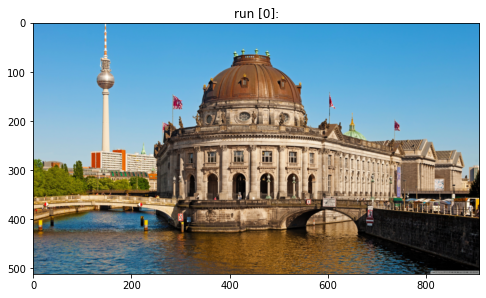

run [500]:
Style Loss : 91551288.000000 Content Loss: 0.012885 time elapsed: 216.48716473579407 seconds


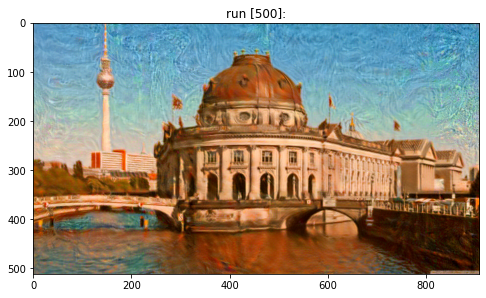

run [0]:
Style Loss : 1665026176.000000 Content Loss: 0.000000 time elapsed: 0.5898029804229736 seconds


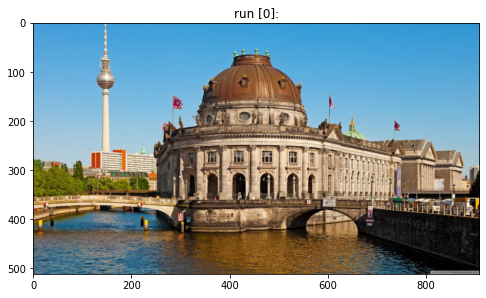

KeyboardInterrupt: ignored

In [ ]:
_ = style_transfer(
    ResNetStyleTransferModel(reg_resnet, dataset.mean, dataset.std), 
    'Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg', 'the_scream.jpg', style_weight=1e17, content_weight=1,
    start_from_content=True, n_iters=range(0, 500, 100), opt='LBFGS')

## Robust ResNet

run [300]:
Style Loss : 0.002783 Content Loss: 0.009654 time elapsed: 129.28519678115845 seconds


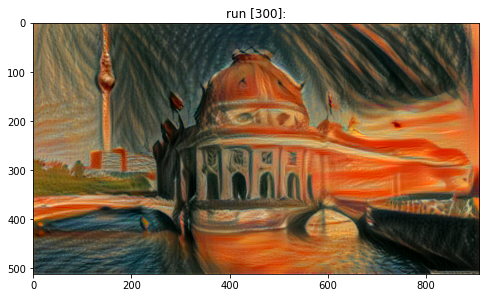

run [300]:
Style Loss : 0.002850 Content Loss: 0.009514 time elapsed: 129.03729915618896 seconds


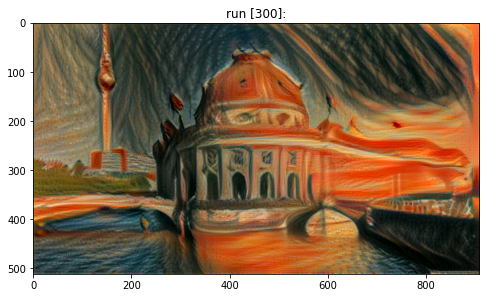

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    'Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg', 'the_scream.jpg', style_weight=1e9, content_weight=1,
    start_from_content=True, n_iters=[0, 300, 400], opt='LBFGS')

## VGG

run [20]:
Style Loss : 27.189352 Content Loss: 5.152471 time elapsed: 12.795108795166016 seconds


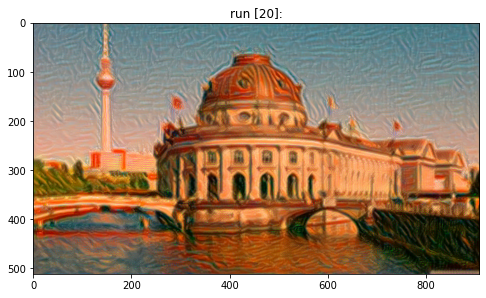

In [ ]:
out = style_transfer(
    VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
    'Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg', 'the_scream.jpg', style_weight=4e6, content_weight=1,
    start_from_content=True, n_iters=[0, 50, 100], content_layers=['conv_10'],
    style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13'], opt='LBFGS')


## Grid search over a bunch of images and hyperparameters

In [ ]:
def create_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
content_img = 'Berlin-Museum-Island-4K-HD-Desktop-Wallpaper-for-4K-Ultra-.jpg'
style_img = 'the_scream.jpg'

style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
content_layers = ['conv_3']
iters = [0, 100, 200]
base_output_directory = 'outputs_images/'
out_dir = os.path.join(
                base_output_directory,
                'si_{}__ci_{}'.format(style_img, content_img),
                )
create_dir(out_dir)
_, outs = style_transfer(
                ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=True, n_iters=iters, style_weight=1e9, content_weight=1,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
for im, i in zip(outs, iters):
  im.save(os.path.join(out_dir, '_{}.jpg').format(i), 'JPEG')

run [0]:
Style Loss : 6.864225 Content Loss: 0.000000 time elapsed: 0.20508074760437012 seconds
run [100]:
Style Loss : 0.003249 Content Loss: 0.010359 time elapsed: 12.279390096664429 seconds
run [200]:
Style Loss : 0.002844 Content Loss: 0.009806 time elapsed: 25.767656087875366 seconds


In [ ]:
#!rm -r outputs_images


In [ ]:
def search_robust():
  base_output_directory = 'outputs_images/'
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  content_layers = ['conv_3']
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_weights = [1e11, 1e10, 1e9, 1e8]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', '1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['dancing.jpg', 'tubingen.jpg', 'working-in-tuebingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['r']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}_{}'.format(sfc, sw, cw, r)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                ResNetStyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_robust()

starting outputs_images/si_the_scream.jpg__ci_dancing.jpg sfcTrue_sw100000000000.0_cw1_r
run [0]:
Style Loss : 222.813080 Content Loss: 0.000000 time elapsed: 0.23293781280517578 seconds
run [50]:
Style Loss : 0.348218 Content Loss: 0.011478 time elapsed: 9.900997161865234 seconds
run [100]:
Style Loss : 0.166779 Content Loss: 0.012694 time elapsed: 20.32696223258972 seconds
run [200]:
Style Loss : 0.099638 Content Loss: 0.013560 time elapsed: 42.32254362106323 seconds
run [300]:
Style Loss : 0.076687 Content Loss: 0.013934 time elapsed: 64.09841775894165 seconds
run [400]:
Style Loss : 0.067099 Content Loss: 0.014042 time elapsed: 85.79176545143127 seconds
run [500]:
Style Loss : 0.062506 Content Loss: 0.014115 time elapsed: 107.49235916137695 seconds
starting outputs_images/si_the_scream.jpg__ci_dancing.jpg sfcFalse_sw100000000000.0_cw1_r
run [0]:
Style Loss : 6004.702148 Content Loss: 0.023428 time elapsed: 0.286043643951416 seconds
run [50]:
Style Loss : 0.817319 Content Loss: 0.01

KeyboardInterrupt: ignored

In [ ]:
!zip -rq outputs_images.zip outputs_images

In [ ]:

def search_nonrobust():
  base_output_directory = 'outputs_images_nonrobust/'
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  content_layers = ['conv_3']
  iters = [0, 50, 100, 200, 500]
  style_weights = [1e14]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', '1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg', 'working-in-tuebingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['nr']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}_{}'.format(sfc, sw, cw, r)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                ResNetStyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_nonrobust()

In [ ]:
!zip -rq outputs_images_nonrobust.zip outputs_images_nonrobust


In [ ]:

def search_vgg():
  base_output_directory = 'outputs_images_vgg/'
  style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
  content_layers = ['conv_10']
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_weights = [1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', '1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}'.format(sfc, sw, cw)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_vgg()

In [ ]:
!zip -rq outputs_images_vgg.zip outputs_images_vgg


In [ ]:
def search_textures():
  base_output_directory = 'outputs_textures/'
  
  vgg_style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
  vgg_content_layers = ['conv_10']

  resnet_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  resnet_content_layers = ['conv_3']
  
  style_weight = 1e9
  
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_images = ['the_scream.jpg', '1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']

  for style_img in style_images:
    for clf in ['r', 'nr', 'vgg']:
      out_dir = base_output_directory
      create_dir(out_dir)
      fn = '{}_{}_texture'.format(clf, style_img)
      existing = glob.glob(os.path.join(out_dir, fn+'_*'))
      if existing:
        print('found {}, skipping', existing[0])
        continue
      print('starting', out_dir, fn)
      if clf == 'vgg':
        model = VGGStyleTransferModel(vgg, dataset.mean, dataset.std)
      else:
        model = ResNetStyleTransferModel(robust_resnet if clf == 'r' else reg_resnet, dataset.mean, dataset.std)
      _, outs = style_transfer(
        model, 
        'dancing.jpg', style_img, start_from_content=False, n_iters=iters, style_weight=style_weight, 
        content_weight=0,
        content_layers=vgg_content_layers if clf == 'vgg' else resnet_content_layers, 
        style_layers=vgg_style_layers if clf == 'vgg' else resnet_style_layers,
        opt='LBFGS', verbose=False)
      for im, i in zip(outs, iters):
        im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_textures()

In [ ]:
!zip -rq outputs_textures.zip outputs_textures